# Time Series Forecasting of Historical GME Data

[Daily GME Historical Dataset](https://www.kaggle.com/hananxx/gamestop-historical-stock-prices)

In [1]:
# Below loads all the preliminaries for the analysis.

# Data Manipulation/Plotting

from math import sqrt
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import simplefilter


# statsmodel for statistical modelling (Exponential Smoothing, Seasonal Decomposition, Dickey Fuller Test - ACF/PACF, ADF Test)

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt   

# Sci-kit learn (and Sktime) for metrics, splitting datasets, converting time series to supervised learning
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)

from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)

from sktime.utils.plotting import plot_series


## Data Preprocessing

Setting the index_col parameter to zero and parsing the dates in the column ensures that the data can be considered time series.

In [2]:
data = pd.read_csv(r'D:\Documents\gamestop.csv', index_col=0, parse_dates=['date'])
data.sort_values(by='date', ascending='True')

,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,
2002-02-13,9.625000,10.060000,9.525000,10.050000,19054000.0,6.766666
2002-02-14,10.175000,10.195000,9.925000,10.000000,2755400.0,6.733003
2002-02-15,10.000000,10.025000,9.850000,9.950000,2097400.0,6.699336
2002-02-19,9.900000,9.900000,9.375000,9.550000,1852600.0,6.430017
2002-02-20,9.600000,9.875000,9.525000,9.875000,1723200.0,6.648838
...,...,...,...,...,...,...
2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002
2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996


Python now recognises this dataset as data recorded over a period of time.

In [3]:
ts = data
ts = ts.sort_index() #Sorts to ascending by default
#ts = ts[725:4000]
ts = ts.asfreq('M')
ts['adjclose_price'].interpolate(method='linear', inplace=True)

The dataset frequency has been changed from daily frequency to monthly frequency. This technique in data science is known as downsampling, and it's purpose is to reduce your sample size for analysis. Because the dataset is spread over the span of 19 years, predicting based on individual days is unnecessary for capturing the overall structure of the data. Graphs become difficult to read, and a larger quantity of computational processing power is required. Thus, monthly frequency is better suited for this analysis.

To account for the loss of data when converting from daily data to monthly data, [linear interpolation](https://www.toppr.com/guides/maths-formulas/linear-interpolation-formula/) was used to fill the missing data.

The chosen variable for the time series was the adjusted close price of GME stocks.

In [4]:
ts = ts['adjclose_price'] #Select close price as the Series data

In [5]:
ts.describe()

count    227.000000
mean      16.586291
std        9.218034
min        2.861525
25%        9.899873
50%       15.439309
75%       21.921356
max       41.818676
Name: adjclose_price, dtype: float64

Standard deviation measure is low, which means that values in the dataset are not very spread out. This makes sense for time series because values will gradually change over time, so they will be closer together. 

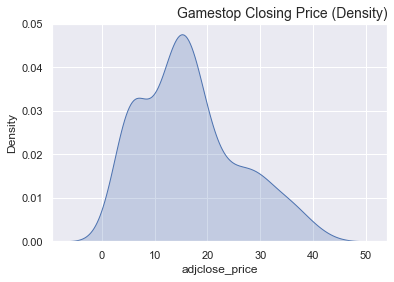

In [6]:
sns.set_style('darkgrid')
sns.kdeplot(ts, shade=True)
plt.title('Gamestop Closing Price (Density)', loc = 'right', fontsize=14)

plt.show()

Density appears to suggest a continuous probability distribution in the form of gamma distribution. For values that can potentially take on a wide range of values, gamma type distribution is likely. For example, [rainfall rates, queue wait times or life expectancy](https://study.com/academy/lesson/gamma-distribution-definition-equations-examples.html) can expect to see gamma type distribution.  

For time series forecasting, as the forecast progresses, elements of the series can take on a wide range of values. This distribution seems appropriate.

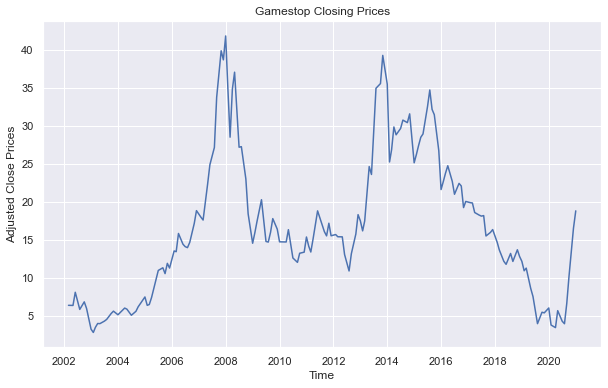

In [7]:
#line graph of closing price, allows for evaluation of seasonality/trend 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Adjusted Close Prices')
plt.plot(ts)
plt.title('Gamestop Closing Prices')
plt.show()


Beginning in 2006, the series measures with low closing prices, gradually increasing, and then peaking in 2008 before plummeting in 2009. Two years later, this same pattern repeats itself from 2011 to 2014. In the fourth quarter of 2015, the trend declines, echoing the same decline as 2009. 


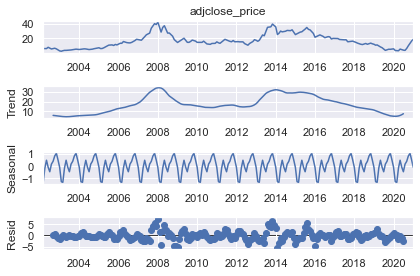

In [8]:
decomp = seasonal_decompose(ts)

decomp.plot()
plt.show()

**Seasonal Decomposition**

Seasonal decomposition describes the mathematical process of converting a single time series into multiple time series. Through this process, underlying features of the time series can be further evaluated:

Trend - Ascending and declining trend is present in this dataset. The trend decline from 2009 to 2014 appears to be steeper than the more gradual decline occuring from 2014 onwards. The peak close price for GME occurred in 2008, with a similar but slightly lower peak occuring in 2014.

Seasonality - In this dataset, the regular peaks that follow a consistent pattern, (2006-2009) and (2011-2014), imply that there is seasonality within this dataset. The decomposition plot appears to show additive seasonality, as indicated by the lack of variation in the patterns as time progresses.

##### Cross-Sectional vs Time Series Data

NOTE: Time series analysis distinguishes itself from cross-sectional analysis by using the additional information provided by ordering on the x-axis, whether it is time or wavelength or something else.

Cross-sectional studies look at only one time point. Longitudinal studies can be repeated measure or time series. Both look at multiple time points, but repeated measure studies usually look at more variables, while time series looks at more time points (usually at least 50) and very few variables (often only one).

What this means is the independent variable doesn't necessarily have to be time in the conventional sense to be a TSA. It can be anything that changes over the distance of the axis (as one variable moves through the axis, another variable also moves).

## Statistical Methods for Time Series Forecasting

### Single Exponential Smoothing: 

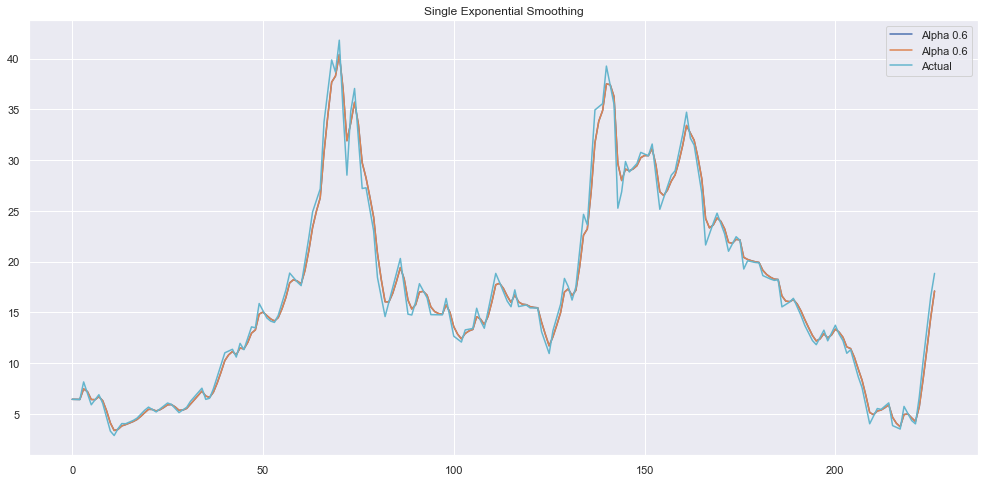

In [9]:
# Sourced from: https://gist.github.com/marcopeix/a9a37792661b57e581414735824e9e9d

def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title('Single Exponential Smoothing')
    plt.grid(True);

plot_exponential_smoothing(ts, [0.6, 0.6])

The alpha parameter functions as the smoothing factor. It decides roughly how well fitted the alpha line will fit to the line plotting the actual data. The higher the alpha parameter is tuned, the more stricter the fit of the alpha line is to the actual line. As shown above, at any alpha measurement, the SES method is incapable capturing the sharpest peaks and troughs in the dataset.

### Double Exponential Smoothing (Holt's Method): 

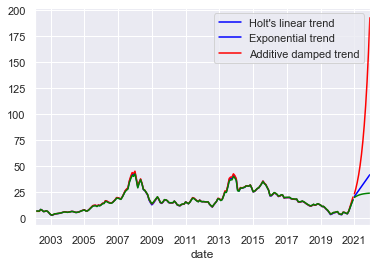

In [10]:
# Sourced from: https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

fit1 = Holt(ts, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

fit2 = Holt(ts, exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast2 = fit2.forecast(12).rename("Exponential trend")

fit3 = Holt(ts, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast3 = fit3.forecast(12).rename("Additive damped trend")

fit1.fittedvalues.plot(color='blue')
fcast1.plot(color='blue', legend=True)

fit2.fittedvalues.plot(color='red')
fcast2.plot(color='red', legend=True)

fit3.fittedvalues.plot(color='green')
fcast3.plot(color='green', legend=True)

plt.show()

Now, the beta parameters are incorporated into the exponential smoothing process, resulting in Double Exponential Smoothing. While the alpha parameters (indicated by the 'smoothing_level' parameter) are maintained for the smoothing factor, the beta parameter (indicated by the 'smoothing_trend' parameter) introduces smoothing for trends in the time series data. As shown by the plot, this allows for more accurate fitting across sharp peaks and troughs. 

### Triple Exponential Smoothing (Holt's-Winter Method)

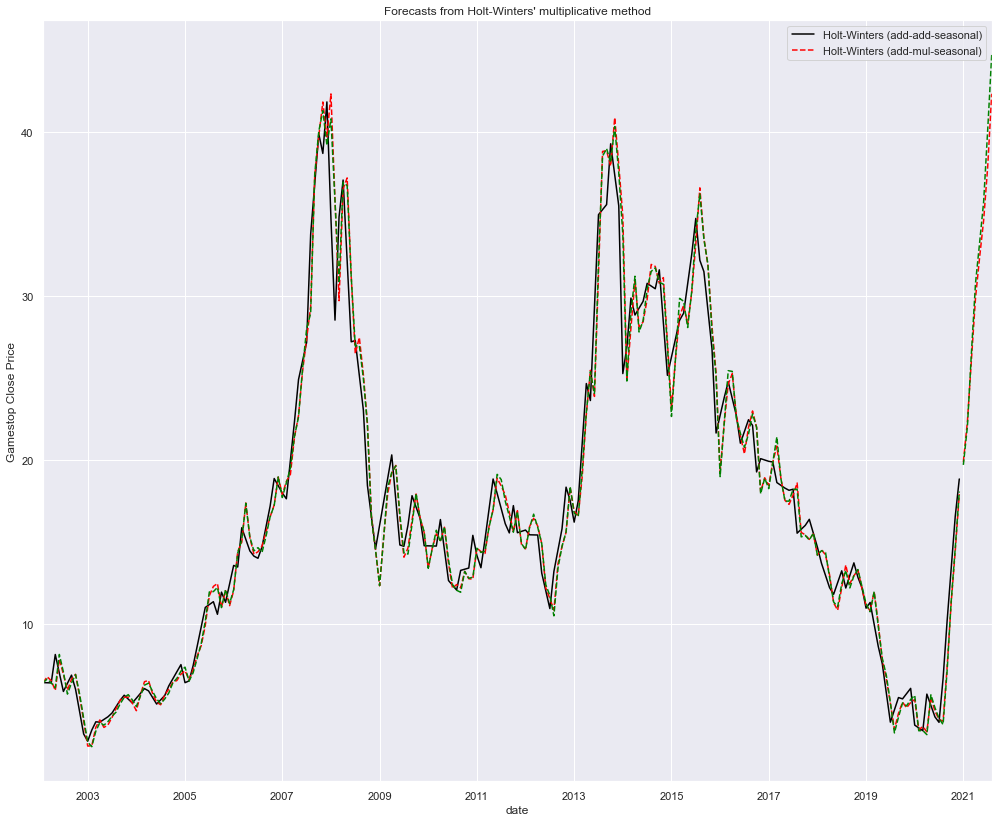


Results: 



,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
$\beta$,1.593955e-01,1.697603e-01,2.331631e-01,2.431302e-01
$\phi$,NaN,NaN,8.000000e-01,8.000000e-01
$\gamma$,9.712548e-09,1.444585e-08,1.101983e-08,1.357705e-08
$l_0$,2.880549e+00,2.006572e+00,2.905378e+00,2.025702e+00
$b_0$,-5.252832e-02,-3.165336e-02,-1.038595e-01,-3.644697e-02
SSE,7.759531e+02,7.076993e+02,7.226437e+02,6.662317e+02


In [11]:
# Sourced from: https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

fit1 = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = ts.plot(figsize=(17, 14), marker='', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Gamestop Close Price")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(8).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='', color='red', legend=True)
fit2.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='', color='green', legend=True)

plt.show()
print("\nResults: \n")
results

Triple Exponential Seasoning introduces the gamma parameter to the technique. This parameter allows for fitting to time series data with seasonality present within it's structure. The statsmodel library enables users to use the most optimised parameters for fitting the trend and seasonality lines, as determined by the library. Judging by the plot, the addition/multiplicative seasonality smoothing does not seem to be as accurate as Double Exponential Smoothing for model fitting. The additive/additive method appears to be more suitable for model fitting as the line closely matches the line representing the time series value.

However, for forecasting, both methods appear to look questionable compared to Double Exponential Smoothing. Here, we can conclude that for a quick predicitive fitting for this particular time series, Double Exponential Smoothing performs the best for both fitting and forecasting.

### Naive Forecaster:

The naive forecaster one of the most simplest forecasting methods. It provides a good baseline of comparison for more complex models utilised in the notebook. By setting the size of the test data to 12, the naive forecasting strategy uses this test data to predict the last 12 values of the dataset. (Sourced from: https://github.com/alan-turing-institute/sktime/blob/main/examples/01_forecasting.ipynb)

In [12]:
y_train, y_test = temporal_train_test_split(ts, test_size=45)
print(y_train.shape[0], y_test.shape[0])

182 45


In [13]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

Mean Absolute Error:  10.191121527883741

Root Mean Squared Error:  11.404066175587873

Mean Absolute Percentage Error:  69.95329624702691 



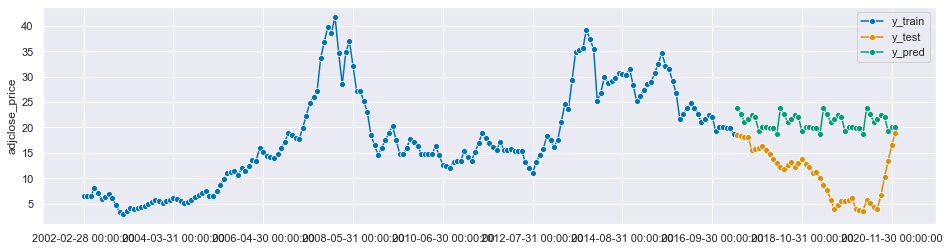

In [14]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("Mean Absolute Error: ", mean_absolute_error(y_pred, y_test))    
print("\nRoot Mean Squared Error: ", sqrt(mean_squared_error(y_pred, y_test)))
print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(y_pred, y_test)*100, "\n")

For the naive forecaster, the dataset was split into training and testing data. For the Sktime library, a forecasting horizon is required for forecasting. The forecasting horizon functions as the independent 'time' variable which the dependent (y) variable is measured against. In our model, the forecasting horizon uses the index of the test data, because this is what we will be testing our forecasting prediction against. In the plot, both the yellow and green line are tested against each other for accuracy. They have the same amount of points. 

The error metric for this model and all models in this analysis will be the mean absolute error, mean absolute percentage error and root mean squared error. As we can see, the MAE measures at 4.3 and the MAPE is measuring at 22%, which indicates a decently fitted model. The average difference between the test values and the predicted values do not measure more than 25%. Furthermore, the average distance from the test values compared to the predicted values is shown by the RMSE, measuring at 4.6. Because accuracy is in the best interest of this analysis, this low average is a very good score for this analysis.

In the analysis, the objective will be to achieve a model that rivals or outperforms this model by scoring lower metrics than the naive forecaster.

---------------------------------------------------

### AutoRegressive (AR) Model

The Augmented Dickey-Fuller Test is a statistical test used for evaluating whether stationarity is present within time series data. This is crucial for any Autoregressive model (AR). The purpose of the test is to determine whether time series is stationary or not. Below, the regular time series values and the differenced time series values are used for the statistical test.

In [15]:
# Augmented Dickey-Fuller Test

ts_diff = ts.diff(2) # Difference data by two
ts_diff = ts_diff.dropna()

In [16]:
# Sourced from: https://predictivehacks.com/arima-model-in-python/ & https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

adf_result=adfuller(ts.values, autolag='AIC')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],adf_result)) # The names of every value have been added
#tsplot(data_diff.values[1:], lags=12)

{'adf': -2.286104495254249,
 'pvalue': 0.17648871960943147,
 'usedlag': 14,
 'nobs': 212,
 'criticalvalues': {'1%': -3.4615775784078466,
  '5%': -2.875271898983725,
  '10%': -2.5740891037735847},
 'icbest': 875.5811879174536}

In [17]:
adf_result=adfuller(ts_diff.values, autolag='AIC')
#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],adf_result))

{'adf': -4.467354707973291,
 'pvalue': 0.00022514508685590544,
 'usedlag': 13,
 'nobs': 211,
 'criticalvalues': {'1%': -3.46172743446274,
  '5%': -2.8753374677799957,
  '10%': -2.574124089081557},
 'icbest': 886.0950679386776}

**ADF Statistic: Non-Differenced = -2.286 // Differenced = -4.039**

The more negative this statistic, the more likely the time series can be considered stationary. A value of -2 for the non-differenced time series indicates a decently strong presence of stationarity. However, with differencing, the statistic falls to -4.039 which suggests an even stronger presence of stationarity in the differenced data. 

**P-value: Non-Differenced = 0.07257 // Differenced = 0.0002**

The non-differenced values fall slightly higher than the statistical significance metric (0.05). This is an indication that we cannot reject the null hypothesis therefore, even if the ADF statistic is negative, we cannot reject the null hypothesis and must assume the data is non-stationary. For the differenced dataset, the p-value falls extremely low with a difference of 1 between the original values and the lagged values. For this value, we can most certainly reject the null hypothesis, which means we can consider the time series stationary. 

---

#### Non-Differenced Values

#### Non-Stationary Autocorrelation Plot:

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


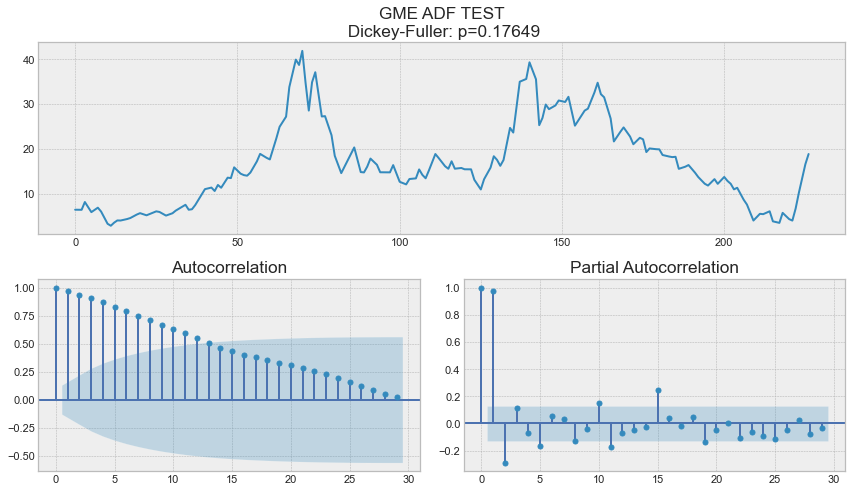

In [18]:
# Sourced from: https://gist.github.com/marcopeix/2f6d69427f3d43e92958ae1bbab86287
# plots normal time series for Dickey-Fuller Test. 

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('GME ADF TEST\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

# lags parameter determines the amount of points to plot for Autocorrelation plots
tsplot(ts.values, lags=29)

The autocorrelation plot shows the lag values along the X-axis, and the correlation along the Y-axis. The plot shows a declining trend of correlation within the dataset. There are 13 lags present. The first lag is actually lag 0, which corresponds to correlation with itself. For this reason, it is measured as 1. The remaining lags indicate the correlation between the values of the time series dataset with a delayed value of itself. For example, correlation measured at lag 2, measures values of the time series that have shifted by 2. In this case, because the frequency is months, it would shift by a lag value of 2 months.

There is huge amount of significant correlation along all lag values in the plot and the decline is very gradual. It is not until lag 9 that we see a significant decrease in correlation in the ACF plot, as this is the first lag to fall below the statistical signifance boundary (blue shade). 

predicted=15.570372, expected=15.432530
predicted=15.022365, expected=15.425751
predicted=15.490238, expected=13.102387
predicted=13.066925, expected=12.023046
predicted=11.824597, expected=10.943704
predicted=11.127513, expected=13.208792
predicted=13.690071, expected=14.506828
predicted=14.300197, expected=15.804864
predicted=16.010432, expected=18.341869
predicted=18.533881, expected=17.531330
predicted=17.200472, expected=16.210720
predicted=16.235348, expected=17.510372
predicted=19.270515, expected=21.083448
predicted=21.803378, expected=24.656525
predicted=24.951672, expected=23.621132
predicted=23.009032, expected=29.284222
predicted=30.977700, expected=34.947311
predicted=35.069201, expected=35.255449
predicted=34.284621, expected=35.563587
predicted=36.673758, expected=39.266788
predicted=41.062219, expected=37.376637
predicted=34.989782, expected=35.486485
predicted=36.088588, expected=25.264132
predicted=22.940488, expected=26.877808
predicted=28.574582, expected=29.864067


C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


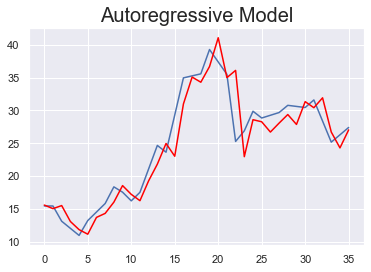

In [19]:
# Sourced from: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = ts.values
ar_train, ar_test = X[0:120], X[121:157]
# train autoregression
window = 12
model = AutoReg(ar_train, lags=12)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = ar_train[len(ar_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(ar_test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = ar_test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
print("\nMean Absolute Error: ", mean_absolute_error(predictions, ar_test))    
print("\nRoot Mean Squared Error: ", sqrt(mean_squared_error(predictions, ar_test)))
print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(predictions, ar_test)*100, "\n")
# plot
plt.plot(ar_test)
plt.title('Autoregressive Model'.format(window), fontsize=20)
plt.plot(predictions, color='red')
plt.show()

#### Differenced Values

#### Stationary Autocorrelation Plot:

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


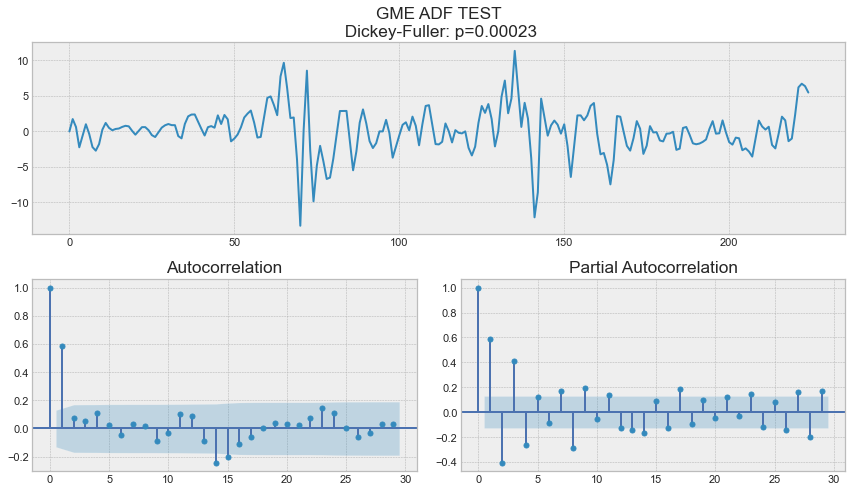

In [20]:
# plots differenced time series for Dickey-Fuller Test
tsplot(ts_diff.values, lags=29)

Differencing the data by 2 results in the lowest p-value that is > 0. As shown in the ACF plot, most of the points are now within the same blue area, and are measuring close to 0.0. This means that the trend from the data has been removed. As mentioned, lag 0 will always measure at 1. The following lags show heavily decreased correlation with the differenced values in comparison to the non-differenced values. In comparison, these values lose correlation instantly after lag 1, and it is only lag 0 & 1 that are statistically significant because it ranks higher than the significance level (indicated by the blue shade).

---

predicted=0.243380, expected=-2.330142
predicted=-2.376106, expected=-3.402705
predicted=-1.384987, expected=-2.158684
predicted=-1.081901, expected=1.185746
predicted=2.718073, expected=3.563124
predicted=1.129040, expected=2.596072
predicted=1.494639, expected=3.835042
predicted=2.861086, expected=1.726466
predicted=-1.114899, expected=-2.131149
predicted=-0.819329, expected=-0.020958
predicted=2.643836, expected=4.872728
predicted=4.789774, expected=7.146152
predicted=3.596325, expected=2.537683
predicted=-0.739797, expected=4.627697
predicted=6.573707, expected=11.326180
predicted=7.050673, expected=5.971228
predicted=-0.541117, expected=0.616276
predicted=2.120058, expected=4.011339
predicted=5.700244, expected=1.813049
predicted=-2.887897, expected=-3.780304
predicted=-1.851593, expected=-12.112505
predicted=-9.945052, expected=-8.608677
predicted=0.716640, expected=4.599936
predicted=4.295708, expected=1.954460
predicted=-5.321298, expected=-0.615463
predicted=1.497469, expected

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


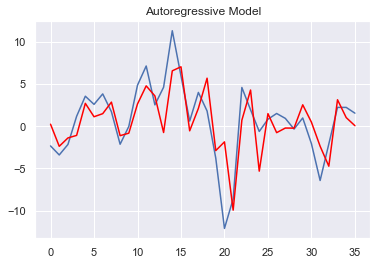

In [21]:
X = ts_diff.values
ar_train, ar_test = X[0:120], X[121:157]
# train autoregression
window = 12
model = AutoReg(ar_train, lags=12)
model_fit = model.fit()
coef = model_fit.params # unclear what parameters these values are supposed to represent

# walk forward over time steps in test
history = ar_train[len(ar_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(ar_test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = ar_test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
print("\nMean Absolute Error: ", mean_absolute_error(predictions, ar_test))    
print("\nRoot Mean Squared Error: ", sqrt(mean_squared_error(predictions, ar_test)))
print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(predictions, ar_test)*100, "\n")
# plot
plt.title('Autoregressive Model'.format(window))
plt.plot(ar_test)
plt.plot(predictions, color='red')
plt.show()



**Test RMSE: 1.525**

This is the Root Mean Square Error for both models. This is the error metric for this model. The closer to 0, the more accurate the models predictions are to the expected values. Judging by the actual prediction and expected values, the model is mostly accurate.

It can be concluded that without differencing, the time series is non-stationary due to it's p-values and significantly higher ADF statistic.

**MAPE: 91.719**

Despite this, the Mean Absolute Error measures drastically higher than the non-differenced time series, which means this model is highly inaccurate.

### Moving Average (MA) Model

Mean Absolute Error 3.172420778816676

Mean Absolute Percentage Error:  19.353664470260668 

Root Mean Squared Error:  10.277737715569423


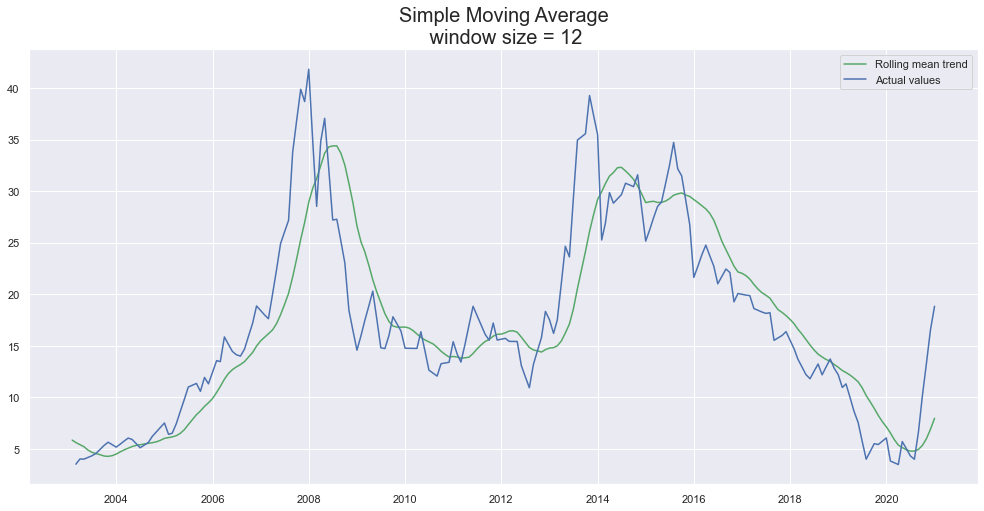

In [22]:
#SMA Taken from: https://gist.github.com/RohanTrix/b2301db8b63dcd9fe0b13a271ac4080c

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Simple Moving Average\n window size = {}'.format(window), fontsize=20)
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        rmse = np.sqrt(((series - window) ** 2).mean())
        
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        #plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        #plt.plot(lower_bound, 'r--')
        #print("Mean Absolute Error: ", mae, "\n")    #uncomment to see MAE and RMSE
        #print("Root Mean Squared Error", rmse, "\n")
    print("Mean Absolute Error", mae)    
    print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(series[window:], rolling_mean[window:])*100, "\n")    
    print("Root Mean Squared Error: ", rmse)
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(ts, 12, plot_intervals=True)

Mean Absolute Error:  1.7946985714363328

Mean Absolute Percentage Error:  118.04716782500668 

Root Mean Squared Error:  5.797993546782134


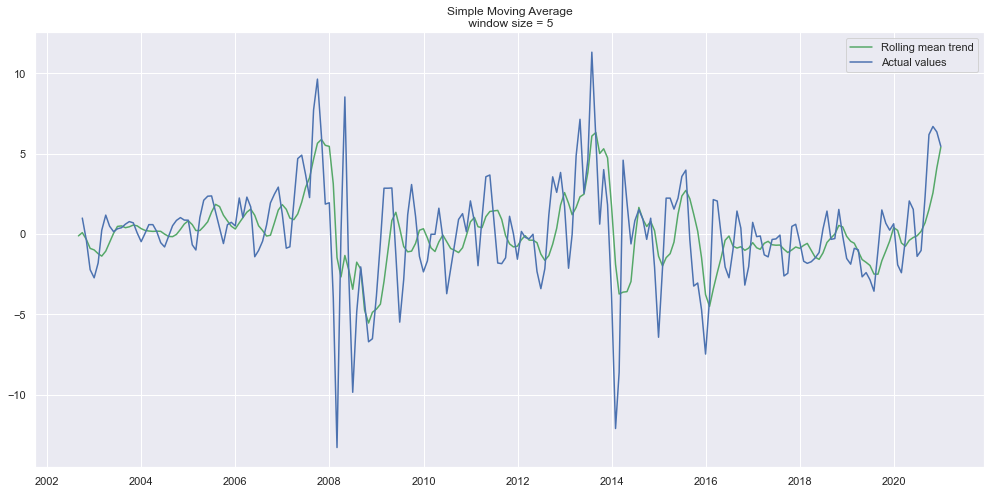

In [23]:
#SMA Taken from: https://gist.github.com/RohanTrix/b2301db8b63dcd9fe0b13a271ac4080c

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Simple Moving Average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        rmse = np.sqrt(((series - window) ** 2).mean())
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        #plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        #plt.plot(lower_bound, 'r--')
        #print("Mean Absolute Error: ", mae, "\n")    #uncomment to see MAE and RMSE
        #print("Root Mean Squared Error", rmse, "\n")
    print("Mean Absolute Error: ", mae)
    print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(series[window:], rolling_mean[window:])*100, "\n")  
    print("Root Mean Squared Error: ", rmse)    
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(ts_diff, 5, plot_intervals=True)

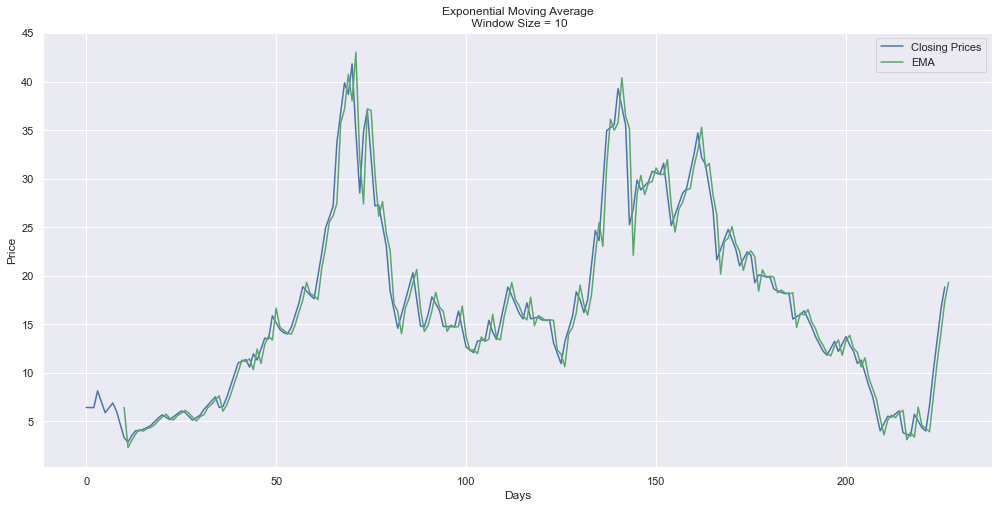

In [24]:
#Function taken from: https://gist.github.com/sohan-py/ab148e7716e1964be2fda42c132c2699#file-ema-py

def calculate_ema(prices, days, smoothing=14.5):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema


ema = calculate_ema(ts, 10)

price_X = np.arange(ts.shape[0]) # Creates array [0, 1, 2, 3, ..., df.shape[0]]
ema_X = np.arange(10, ts.shape[0]+1) # Creates array [10, 11, 12, 13, ..., df.shape[0]+1]
                                     # We start at 10, because we use the first 10 values to calculate the SMA,
                                     # then we calculate EMA form the 11th valu
plt.figure(figsize=(17,8))
plt.title('Exponential Moving Average\n Window Size = 10')        
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(price_X, ts, label='Closing Prices')
plt.plot(ema_X, ema, label='EMA', color = 'g')
plt.legend()
#print("RMSE: ", sqrt(mean_absolute_error(ema, ts))) # Unable to calculate RMSE correctly
plt.show()

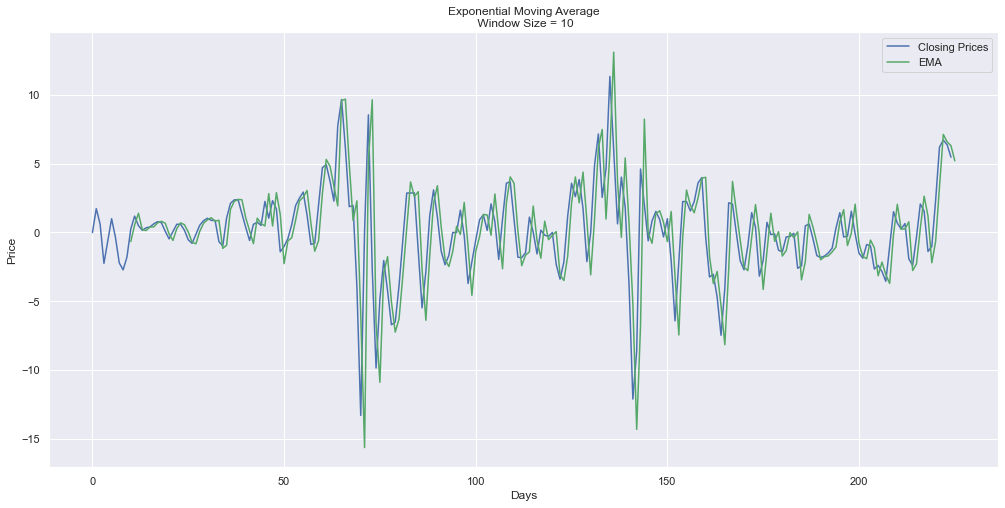

In [25]:
#Function taken from: https://gist.github.com/sohan-py/ab148e7716e1964be2fda42c132c2699#file-ema-py

def calculate_ema(prices, days, smoothing=14.5):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema


ema = calculate_ema(ts_diff, 10)

price_X = np.arange(ts_diff.shape[0]) # Creates array [0, 1, 2, 3, ..., df.shape[0]]
ema_X = np.arange(10, ts_diff.shape[0]+1) # Creates array [10, 11, 12, 13, ..., df.shape[0]+1]
                                     # We start at 10, because we use the first 10 values to calculate the SMA,
                                     # then we calculate EMA form the 11th valu
plt.figure(figsize=(17,8))
plt.title('Exponential Moving Average\n Window Size = 10')        
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(price_X, ts_diff, label='Closing Prices')
plt.plot(ema_X, ema, label='EMA', color = 'g')
plt.legend()
#print("RMSE: ", sqrt(mean_absolute_error(ema, ts))) # Unable to calculate RMSE correctly
plt.show()

The test RMSE for Simple Moving Average measures higher for non-differenced time series than the differenced time series. This suggests that differenced data is neccessary for a moving average model. Even though this is the case, the line appears to fit much better for Exponential Moving Average. For this analysis, the calculation for RMSE for Exponential Moving Average was unable to be calculated, therefore, the error metric of the model could not be calculated.



### ARIMA Model

In [26]:
import pmdarima as pm
from pmdarima.arima import auto_arima

First, the data was split into testing and training data. 80% of the data was used for training and 20% was used for testing. This was accomplished by splitting the length of the time series index first, by multiplying the length of the time series index by the size (0.8) of the training data. Then the training and testing variables were created using integer location indexing.

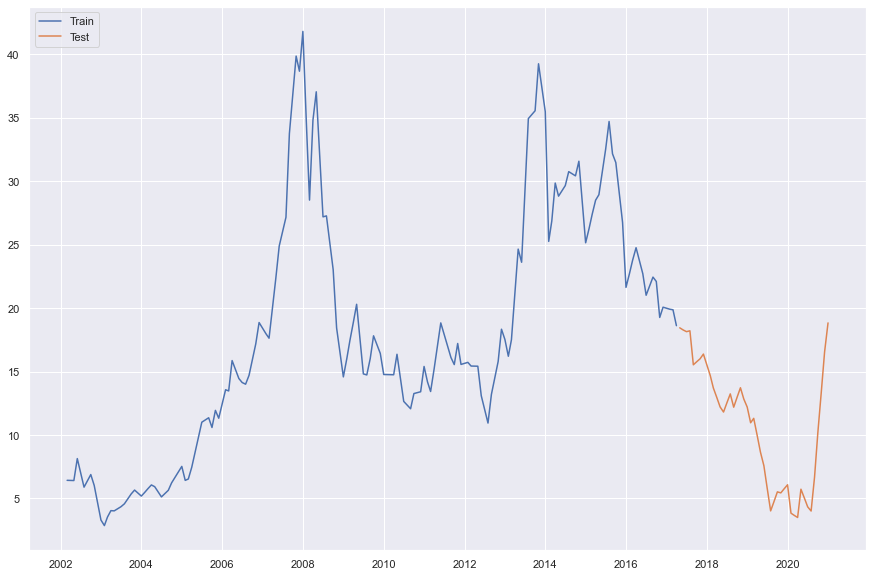

In [27]:
# Train/Test Index Split
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

# Series Split
arima_train = ts.iloc[:split_idx]
arima_test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(15,10))
plt.plot(arima_train, label='Train')
plt.plot(arima_test, label='Test')
ax.legend(loc = 'upper left')

In [28]:
# Sourced from: https://alkaline-ml.com/pmdarima/quickstart.html

arima_model = auto_arima(arima_train, start_p=0, start_q=0,
                             max_p=5, max_q=5, m=12,
                             start_P= 0, start_D = 0, start_Q= 0, 
                             seasonal=True, stationary = False,
                             d=1, D=1, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True,  
                             stepwise=False)  
arima_model.summary()



 ARIMA(0,1,0)(0,1,0)[12]             : AIC=838.863, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=794.966, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=782.889, Time=0.19 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=832.827, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=790.390, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.14 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=775.787

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  182
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -383.894
Date:                             Mon, 28 Jun 2021   AIC                            775.787
Time:                                     17:51:39   BIC                            788.307
Sample:                                          0   HQIC                           780.868
                                             - 182                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2395      0.063      3.797      0.000       0.116       0.363
ar.S.L12      -0.6343      0.057    -11.184      0.000      -0.745      -0.523
ar.S.L24      -0.3002      0.083     -3.613      0.000      -0.463      -0.137
sigma2         5.3237      0.414     12.850      0.000       4.512       6.136
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                36.39
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.73   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For the ARIMA model, the pmdarima library was used. This library is a port of the auto.arima function from the R forecast library. It utilises a grid search method to attempt all hyperparameter combinations for comparing the best results. The best model is chosen based on the lowest AIC measurement. The model received was the SARIMAX variant of the ARIMA model which takes into account seasonality (S) and exogenous variables (X). 

#### Hyperparameters:

* Start p and q: The start p, q and d for the ARIMA component were set to 0 because it is more suitable for the grid search to iterate through all possible parameters starting from 0. 

* Start P and Q: The start P, Q and D for the seasonal component of the ARIMA model were set to 0 because it is more suitable for the grid search to iterate through all possible parameters starting from 0. 

* d and D: The differencing (integrated) component of the SARIMAX model was set to 1. There was seasonality in the dataset as seen in prior analysis using only the Autoregressive model which required differencing. When set to 0, this results in worse predictions.

* Seasonality: Set to TRUE. The time series training data does contain seasonality so the model search has been limited to only stationary ARIMA models. Setting this to False results in inaccurate predictions. 

* Stationarity: Set to FALSE. The inputted time series training data is not stationary. Therefore, the search should include models that are non-stationary. Setting this to True results in more accuracy according to RMSE but loses the trend of the data. Using differenced values also results in worse accuracy.  

* Stepwise: Set to False. Stepwise search is less thorough than non-stepwise search. Non-stepwise search is known as parallelised search. This method brute force attempts every possible combination for the lowest AIC. 

#### Summary:

The main metrics of interest in the summary is 'P>|z|'

* P>|z| - This indicates the p-values, which we want to be as close to 0 as possible. Nearly all of them are close to zero which is a good sign for the model. 

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


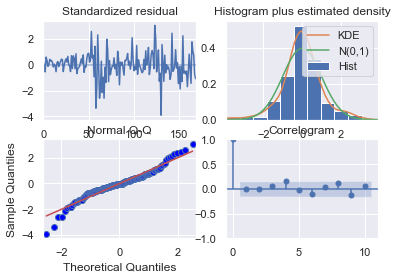

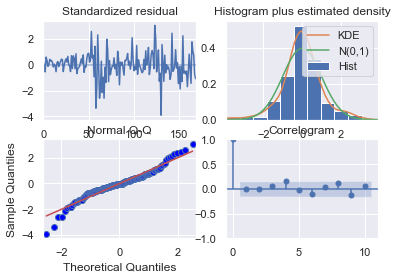

In [29]:
arima_model.plot_diagnostics()

In [30]:
# Sourced from: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

prediction = pd.DataFrame(arima_model.predict(n_periods = 45), index=arima_test.index)

prediction.columns = ['predicted_close_price']

print(prediction, "\nArima Test Data: \n", arima_test)
#print(

            predicted_close_price
date                             
2017-04-30              17.487850
2017-05-31              17.836255
2017-06-30              17.940011
2017-07-31              19.262921
2017-08-31              18.622364
2017-09-30              18.216125
2017-10-31              16.736275
2017-11-30              15.278270
2017-12-31              12.574100
2018-01-31              13.238457
2018-02-28              13.917686
2018-03-31              14.123036
2018-04-30              13.496334
2018-05-31              13.819012
2018-06-30              13.828746
2018-07-31              15.208665
2018-08-31              14.447329
2018-09-30              13.976571
2018-10-31              11.779196
2018-11-30              10.807353
2018-12-31               8.255013
2019-01-31               8.792884
2019-02-28               9.349778
2019-03-31               9.300949
2019-04-30               8.384878
2019-05-31               8.311091
2019-06-30               7.840284
2019-07-31    

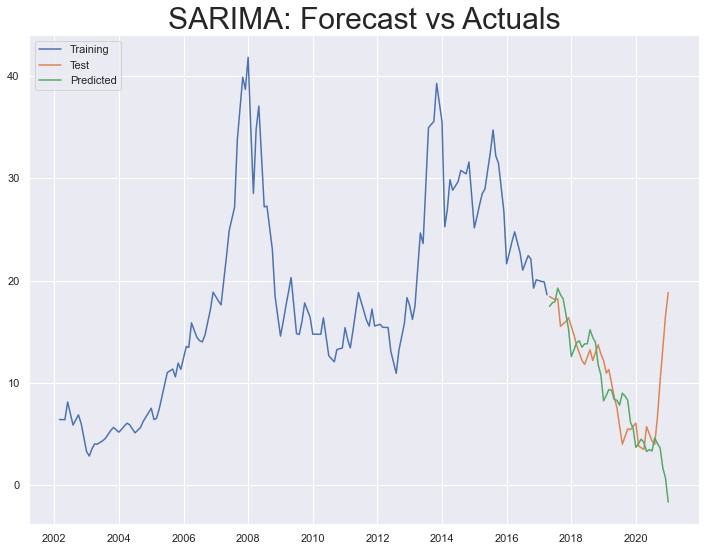

In [31]:
#forecasting with ARIMA

plt.figure(figsize=(12, 9))
plt.title("SARIMA: Forecast vs Actuals", fontsize=30)
plt.plot(arima_train, label = "Training")
plt.plot(arima_test, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc = "upper left")
plt.show()

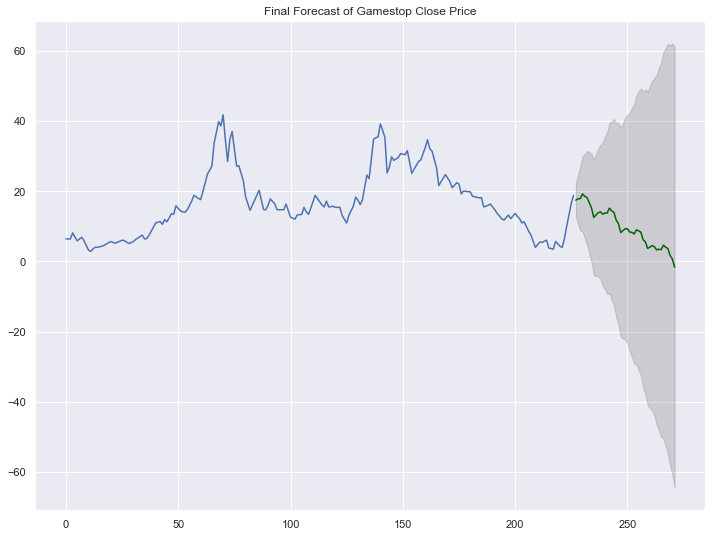

In [32]:
# Forecast
n_periods = 45
fc, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(ts.values), len(ts.values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12, 9))
plt.plot(ts.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Gamestop Close Price")
plt.show()

In [33]:
# Sourced from: https://medium.com/analytics-vidhya/get-started-with-time-series-forecasting-in-python-c8ca78ee84a5

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-arima_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, arima_test.values)

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


{'mape': 0.2672342843837038,
 'me': -1.0825615910447728,
 'mae': 2.6880099345479618,
 'mpe': -0.03809934860843529,
 'rmse': 4.7335736500464485,
 'acf1': 0.7099925067205785,
 'corr': 0.6094016443963186,
 'minmax': 0.23140975297261013}

#### Prediction Values & Forecast Plot:

As shown by the prediction values and the test data values, as the time progresses, the predictions become more inaccurate. In the plot, the predicted values progress further into the incorrect direction of the test values. It appears as if the values are inverted. The test values progress lower and the prediction values progress higher. 

#### Metric Summary: 

The predictions appear to resemble the predicitions of the naive model. The predictions maintain accuracy as as time progresses although, the results are marginally more inaccurate as time progresses further into the future. This is to be expected. Compared to the naive model MAPE score of 69.07, the ARIMA model scored 0.27 for it's MAPE metric, which indicates a huge outperformance. Also, similar to the naive model, the time progression results in the predicitions exponentially predicting into the opposite direction although, in the ARIMA model, the magnitude of the incorrect predictions are less severe. MAE and RMSE rank fairly low which is consistent with the mostly accurate results. As explained above, there are ways of tuning the parameters to get the metrics to rank lower however, much of the trend information is lost during this process and sense cannot be made from the plot, even if the direction of the prediction is closer to the one we currently have. Overall, the ARIMA model appears to be more accurate in it's predictions. 

## Machine Learning Methods for Time Series Analysis

### K Neighbours Regression for Time Series Forecasting

In [34]:
# Sourced from: https://github.com/alan-turing-institute/sktime/blob/main/examples/01_forecasting.ipynb

from sklearn.neighbors import KNeighborsRegressor
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=60, strategy="recursive")

In [35]:
y_train, y_test = temporal_train_test_split(ts, test_size=36)
print(y_train.shape[0], y_test.shape[0])

191 36


In [36]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', freq='M', is_relative=False)


Mean Absolute Error:  6.953233748674393

Mean Absolute Percentage Error:  0.6053890761170475

Root Mean Squared Error:  7.831103653010155


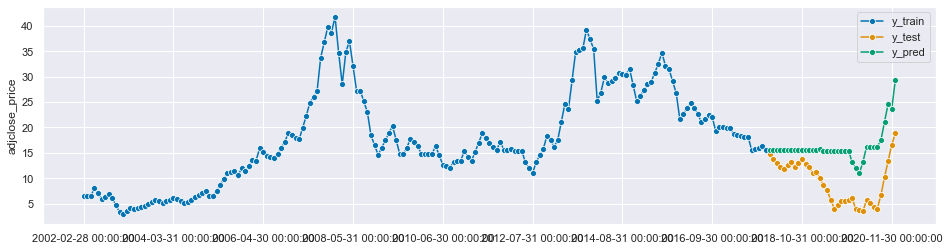

In [37]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("\nMean Absolute Error: ", mean_absolute_error(y_pred, y_test)) 
print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(y_pred, y_test))
print("\nRoot Mean Squared Error: ", sqrt(mean_squared_error(y_pred, y_test)))

In [38]:
forecaster.get_params()

{'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 1,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsRegressor(n_neighbors=1),
 'step_length': 1,
 'window_length': 60}

In [39]:
print("Predictions: \n", y_pred, "\n")
print("Test Data: \n", y_test)

Predictions: 
 2018-01-31    15.534478
2018-02-28    15.534478
2018-03-31    15.534478
2018-04-30    15.534478
2018-05-31    15.534478
2018-06-30    15.534478
2018-07-31    15.534478
2018-08-31    15.534478
2018-09-30    15.534478
2018-10-31    15.534478
2018-11-30    15.534478
2018-12-31    15.534478
2019-01-31    15.566702
2019-02-28    15.647497
2019-03-31    15.728292
2019-04-30    15.439309
2019-05-31    15.432530
2019-06-30    15.432530
2019-07-31    15.432530
2019-08-31    15.432530
2019-09-30    15.432530
2019-10-31    15.425751
2019-11-30    15.425751
2019-12-31    13.102387
2020-01-31    12.023046
2020-02-29    10.943704
2020-03-31    13.208792
2020-04-30    16.210720
2020-05-31    16.210720
2020-06-30    16.210720
2020-07-31    16.210720
2020-08-31    17.510372
2020-09-30    21.083448
2020-10-31    24.656525
2020-11-30    23.621132
2020-12-31    29.284222
dtype: float64 

Test Data: 
 date
2018-01-31    14.686983
2018-02-28    13.708433
2018-03-31    12.962601
2018-04-30    

### Gradient Boosted Trees for Time Series Forecasting

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


>expected=22.7, predicted=23.0
>expected=23.8, predicted=21.9
>expected=24.8, predicted=24.7
>expected=23.7, predicted=25.1
>expected=22.7, predicted=25.1
>expected=21.0, predicted=24.0
>expected=21.7, predicted=21.1
>expected=22.5, predicted=22.7
>expected=22.1, predicted=23.5
>expected=19.3, predicted=22.2
>expected=20.1, predicted=18.2
>expected=20.0, predicted=20.1
>expected=19.9, predicted=21.5
>expected=19.9, predicted=20.4
>expected=18.6, predicted=20.0
>expected=18.5, predicted=18.6
>expected=18.3, predicted=18.4
>expected=18.1, predicted=19.1
>expected=18.2, predicted=19.1
>expected=15.5, predicted=19.8
>expected=15.8, predicted=17.1
>expected=16.0, predicted=16.9
>expected=16.4, predicted=17.4
>expected=15.5, predicted=15.4
>expected=14.7, predicted=15.4
>expected=13.7, predicted=14.3
>expected=13.0, predicted=13.5
>expected=12.2, predicted=12.6
>expected=11.8, predicted=12.5
>expected=12.5, predicted=13.0
>expected=13.2, predicted=13.5
>expected=12.2, predicted=13.8
>expecte

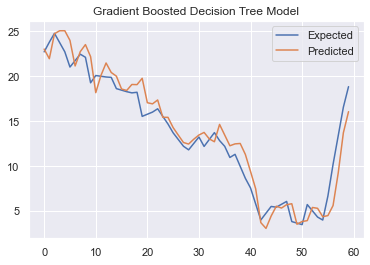

In [40]:
# Sourced from: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

from xgboost import XGBRegressor
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[0]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    mse = sqrt(mean_squared_error(test[:, -1], predictions)) #Not functioning as intended
    print("\nRoot Mean Squared Error: ", mse)
    print("\nMean Absolute Percentage Error: ", mean_absolute_percentage_error(test[:, -1], predictions)*100, "\n")
    return error, test[:, -1], predictions
 
# load the dataset
series = pd.read_csv('D:\Documents\gamestop.csv', header=0, index_col=0)
values = ts.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 60)
print('Mean Absolute Error: %.3f' % mae)
# plot expected vs preducted
plt.title("Gradient Boosted Decision Tree Model")
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()